<font size=7>Control Electrode Clustering

# <font color="grey"> Setup

In [1]:
from human_hip import spike_data
import numpy as np
from human_hip.spike_data import *
import pickle

In [8]:
from matplotlib import pyplot as plt
from human_hip.raw_data import get_brain_waves, cwt_spectrogram, spectrogram_plot, butter_filter
from human_hip.spike_data import read_autocurated_data, plot_raster
import numpy as np
from scipy.ndimage import gaussian_filter1d

from scipy.signal import hilbert, correlate
from astropy.stats import rayleightest, circmean, circstd

# Packages for plotting spectrogram
from scipy import ndimage
from matplotlib.colors import LogNorm #Normalize
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pickle 
from human_hip.histology import plot_histology, plot_histology_electrode_map
from human_hip.spike_data import read_phy_files, read_autocurated_data

import os
from sklearn.cluster import KMeans
import pandas as pd

# !pip install statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [11]:
# general functions

def compute_rate_isi(sd, GAUSS_SIGMA=50, TIME_RANGE=[9,28]):
    
    if TIME_RANGE[0] < 0:
        TIME_RANGE[0] = 0
        print("WARNING: Start time set to 0s")

    # make empty result arrays
    rate_mat = np.zeros((len(sd.train), TIME_RANGE[1]*1000-TIME_RANGE[0]*1000))
    
    # for each unit
    for unit in range(len(sd.train)):
        
        # get spike times from sd
        spk_times= np.unique( np.round(sd.train[unit]).astype(int) )

        # remove spikes outside of time range under consideration
        spk_times = [x for x in spk_times if TIME_RANGE[0]*1000 <= x <= TIME_RANGE[1]*1000]

        # compute ISIs
        isi = np.diff(spk_times)
        
        # add spacer so that indices are the same
        isi = np.insert(isi, 0, 1)
        
        # compute firing rate based on isi
        isi_rate = 1/isi

        # make temporary result array
        isi_rate_temp_result = np.zeros((TIME_RANGE[1]*1000-TIME_RANGE[0]*1000, 1))
        
        # for each spike except the first
        for spk in range(1, len(spk_times)):
            
            # store rates at corresponding spike times
            isi_rate_temp_result[spk_times[spk-1]-TIME_RANGE[0]*1000:spk_times[spk]-TIME_RANGE[0]*1000] = isi_rate[spk]

        # compute firing rates and store
        rate_mat[unit,:] = 1000*gaussian_filter1d(isi_rate_temp_result, GAUSS_SIGMA).squeeze()
    
    return rate_mat

# # #

def compute_cross_corr_lag_range(input_data, MAX_LAG, norm=True):

    # Initialize the output matrices
    max_corr = np.zeros((input_data.shape[0], input_data.shape[0]))
    lag_times = np.zeros((input_data.shape[0], input_data.shape[0]))

    # Compute the cross-correlations
    for i in range(input_data.shape[0]):
        print(i)

        signal1_scaled = input_data[i, :] - np.mean(input_data[i, :])
        if norm:
            signal1_scaled = signal1_scaled / np.linalg.norm(signal1_scaled)

        for j in range(input_data.shape[0]):
            if i != j:

                signal2_scaled = input_data[j, :] - np.mean(input_data[j, :])
                if norm:
                    signal2_scaled = signal2_scaled / np.linalg.norm(signal2_scaled)

                r = correlate(signal1_scaled, signal2_scaled, mode='full')
                r = r[r.size // 2 - MAX_LAG: r.size // 2 + MAX_LAG + 1] 
                r_norm = r / (np.std(signal1_scaled) * np.std(signal2_scaled) * len(signal1_scaled))
                if np.max(r_norm)>1:
                    print(len(input_data[i, :]))
                    print(len(input_data[j, :]))
                    print(np.std(input_data[i, :]) * np.std(input_data[j, :]) * len(input_data[i, :]))
                    print("ERROR")
                max_corr[i, j] = np.max(r_norm) #r[np.argmax(np.abs(r))] #  
                lag_times[i, j] = np.argmax(np.abs(r_norm)) - MAX_LAG
            else:
                max_corr[i, j] = 1  # Autocorrelation is 1 at lag 0
                lag_times[i, j] = 0

    return max_corr, lag_times

# # #

# Function to find the k closest rows
def find_k_closest_rows(arr1, arr2, k):
    distances = np.linalg.norm(arr1[:, np.newaxis] - arr2, axis=2)
    closest_indices = np.argsort(distances, axis=1)[:, :k]
    return closest_indices

# # #

# population rate for selection of units
def compute_clus_pop_rate(sd, selec_units):

    # make spikedata object of subset of units
    subset_sd = sd[selec_units]

    # compute population rate for subset
    pop_fr = gaussian_filter1d(subset_sd.binned(bin_size=1).astype(float), sigma=20)

    return pop_fr

# # #

def plot_clus_pop_rate(pop_fr0, pop_fr1, x_lim):

    # Create the figure and axis
    fig, ax = plt.subplots()

    # get x-values
    x_vals = np.linspace(0, len(pop_fr0)/1000, len(pop_fr0)+1)[1:]

    # Plot the lines
    ax.plot(x_vals, pop_fr0, color='blue', label='Clus0')
    ax.plot(x_vals, pop_fr1, color='red', label='Clus1')

    # Add a legend
    ax.legend()

    # specify xlim
    plt.xlim(x_lim)

    # Show the plot
    plt.show()

# # #

def plot_clus_pop_rate_theta(pop_fr0, pop_fr1, x_lim):

    # obtain population firing rate for x_lim only
    pop_fr0_cut = pop_fr0[x_lim[0]*1000:x_lim[1]*1000]
    pop_fr1_cut = pop_fr1[x_lim[0]*1000:x_lim[1]*1000]

    # filter firing rate for theta frequency
    pop_fr0_cut_theta = butter_filter(pop_fr0_cut, 4, 8, fs=1000)
    pop_fr1_cut_theta = butter_filter(pop_fr1_cut, 4, 8, fs=1000)

    # Create the figure and axis
    fig, ax = plt.subplots()

    # get x-values
    x_vals = np.linspace(x_lim[0],x_lim[1],len(pop_fr0_cut_theta)+1)[1:]

    # Plot the lines
    ax.plot(x_vals, pop_fr0_cut_theta, color='blue', label='Clus0')
    ax.plot(x_vals, pop_fr1_cut_theta, color='red', label='Clus1')

    # Add a legend
    ax.legend()

    # specify xlim
    plt.xlim(x_lim)

    # Show the plot
    plt.show()

<font color="red"> OLD

In [ ]:

# # Create a figure with a 2x2 subplot layout
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# # Plot the original max_corr heatmap
# im1 = ax1.imshow(max_corr, cmap='viridis')
# ax1.set_title('Original Maximum Correlation')

# # Plot the original lag_times heatmap with the bwr colormap
# im2 = ax2.imshow(lag_times, cmap='bwr')
# ax2.set_title('Original Lag Times')
# ax2.set_xlabel('to')
# ax2.set_ylabel('from')

# # Plot the reordered max_corr heatmap
# im3 = ax3.imshow(reordered_max_corr, cmap='viridis')
# ax3.set_title('Reordered Maximum Correlation')

# # Plot the reordered lag_times heatmap with the bwr colormap
# im4 = ax4.imshow(reordered_lag_times, cmap='bwr')
# ax4.set_title('Reordered Lag Times')
# ax4.set_xlabel('to')
# ax4.set_ylabel('from')

# # Show the colorbars
# fig.colorbar(im1, ax=ax1, label='Correlation Coefficient')
# fig.colorbar(im2, ax=ax2, label='Lag (ms)')
# fig.colorbar(im3, ax=ax3, label='Correlation Coefficient')
# fig.colorbar(im4, ax=ax4, label='Lag (ms)')

# plt.tight_layout()
# plt.show()
# # plt.savefig(fig_save_path + "2023-12-03-e-Hc112823_avv9hckcr1_acid1_theta_corr_data_start{}s_stop{}s_maxlag{}.png".format(sb[0], sb[1], MAX_LAG))
# # print("correlation matrix figure saved")



# # Create the scatterplot
# plt.figure(figsize=(10, 10))

# for label in np.unique(labels):
#     cluster_av_corr = avg_corr_scores[labels==label]
#     cluster_av_corr[cluster_av_corr<0]=0
#     cluster_xy = elec_xy[labels == label,:]
#     plt.scatter(cluster_xy[:, 0], cluster_xy[:, 1], s=cluster_av_corr * 100, c=['blue' if label == 0 else 'red'],
#                 alpha=0.5)

# # Set the aspect ratio to 'equal'
# # plt.gca().set_aspect('equal')

# plt.tight_layout()
# plt.show()

# HC52

# Create raster

(<Axes: xlabel='Time (s)', ylabel='Neural Unit'>,
 <Axes: xlabel='Time (ms)', ylabel='Population Firing Rate (Hz)'>)

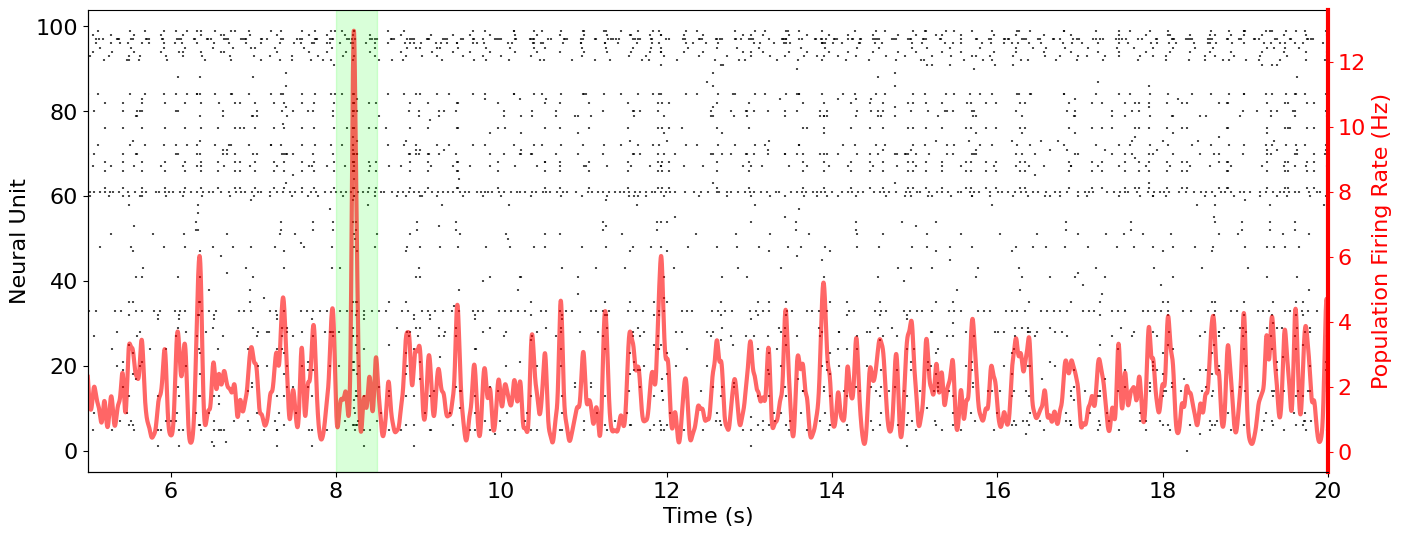

In [39]:
with open('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/5-10-23s1-CutData.pkl', 'rb' ) as my_file:
    sd = pickle.load(my_file)
raw_recordings= np.array([ [8,8.5] ])
spike_data.plot_raster( sd, opto=raw_recordings, xlim=(5,20)  )

In [4]:
# load LFP data
with open("/workspaces/human_hippocampus/data/ephys_raw/2023-05-10-e-hc52_18790_unperturbed/raw_start6s_stop16s_fs1ms.pkl", 'rb') as filename:
    data_raw = pickle.load(filename)
print(data_raw.keys())
print(data_raw["data"].shape)

dict_keys(['data', 'xy', 'frame_rate', 'start_time', 'stop_time', 'file', 'UUID'])
(1017, 10000)


In [12]:
start = 2000
end = 2500

## Do Clustering

In [9]:
# filter LFP data into individual frequency bands
data = get_brain_waves(data_raw["data"], data_raw["frame_rate"]) #[wave_type]  # get common brain waves

print(data.keys())
print(data["theta"].shape)

dict_keys(['original', 'basic', 'low', 'delta', 'theta', 'alpha', 'beta', 'gamma'])
(1017, 10000)


In [16]:
# Set the maximum lag time in ms (1 theta cycle is 125-250ms)
MAX_LAG = 40
NCLUS = 2
SEED = 1
# obtain electrode coordinates
elec_xy = data_raw["xy"].copy()

In [13]:
print("computing correlations")
# get theta filtered data
theta_filt = data["theta"]
print(theta_filt.shape)
max_corr, lag_times = compute_cross_corr_lag_range(theta_filt[:,2000:2500], MAX_LAG, norm=False) # 0:5300


computing correlations
(1017, 10000)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
2

In [15]:



# Perform k-means clustering on the lag_times matrix
kmeans = KMeans(n_clusters=NCLUS, random_state=SEED).fit(lag_times)
labels = kmeans.labels_

# Reorder the matrices based on the cluster labels
reordered_max_corr = max_corr[:, np.argsort(labels)][np.argsort(labels), :]
reordered_lag_times = lag_times[:, np.argsort(labels)][np.argsort(labels), :]

# Compute the average correlation score within each cluster
avg_corr_scores = np.zeros_like(labels, dtype=float)
for i in np.unique(labels):
    cluster_corr = max_corr[labels == i, :]
    cluster_corr = cluster_corr[:, labels == i]
    avg_corr_scores[labels == i] = np.mean(cluster_corr, axis=0)


Text(0, 0.5, 'um')

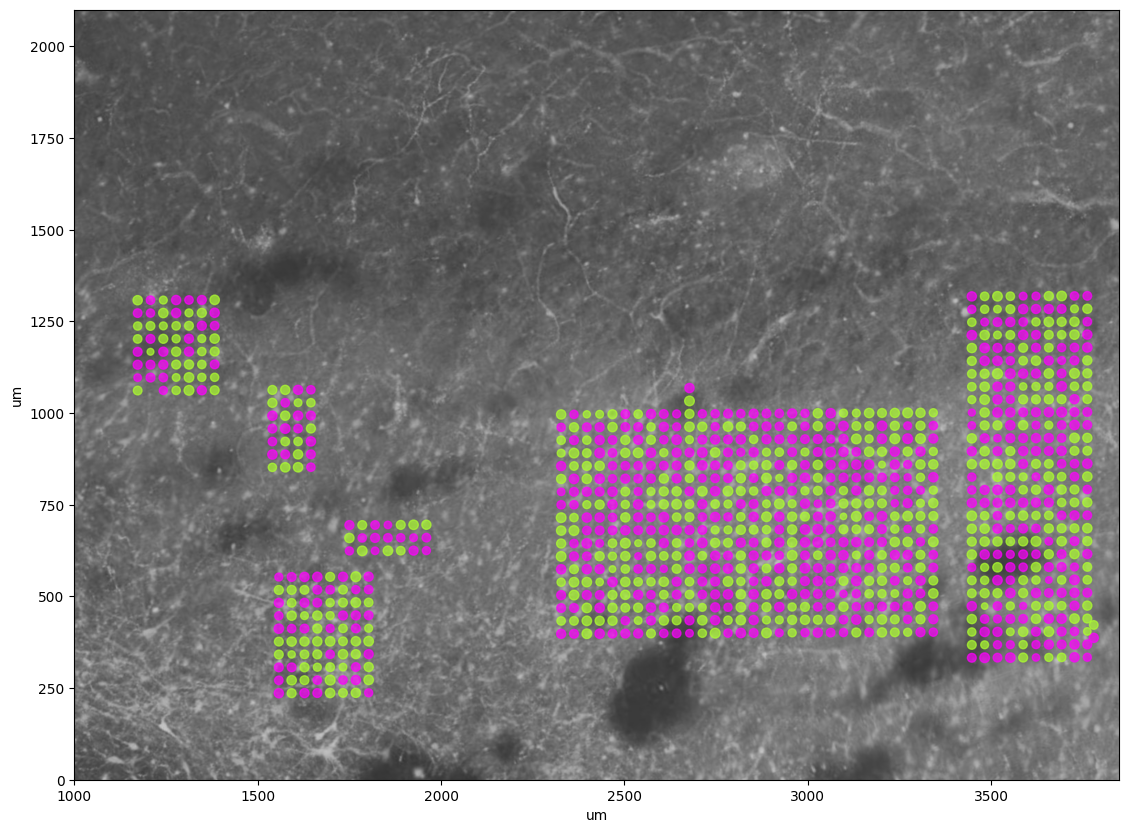

In [31]:

plt.figure(figsize=(15,10))       # Set image size to roughly the shape of the MEA
img = plt.imread( "/workspaces/human_hippocampus/data/histology/hc52_bw4.png")       # Load in image
plt.imshow(img,  extent=[0, 3850, 0, 2100]) # Plot image, have it correspond to electrode dimensions
electrode_mapping =  pd.DataFrame.from_dict( sd.metadata[0], orient="index", columns=['x','y']  ) 


for label in np.unique(labels):
    cluster_av_corr = avg_corr_scores[labels==label]
    cluster_av_corr[cluster_av_corr<0]=0
    cluster_xy = elec_xy[labels == label,:]
    plt.scatter(cluster_xy[:, 1], cluster_xy[:, 0]/12.5, s=cluster_av_corr * 100, c=['fuchsia' if label == 0 else 'greenyellow'],
                alpha=0.7)

plt.xlim( 1000,3850 )    
plt.xlabel('um')                                         # add axises and title
plt.ylabel('um')


Text(0, 0.5, 'um')

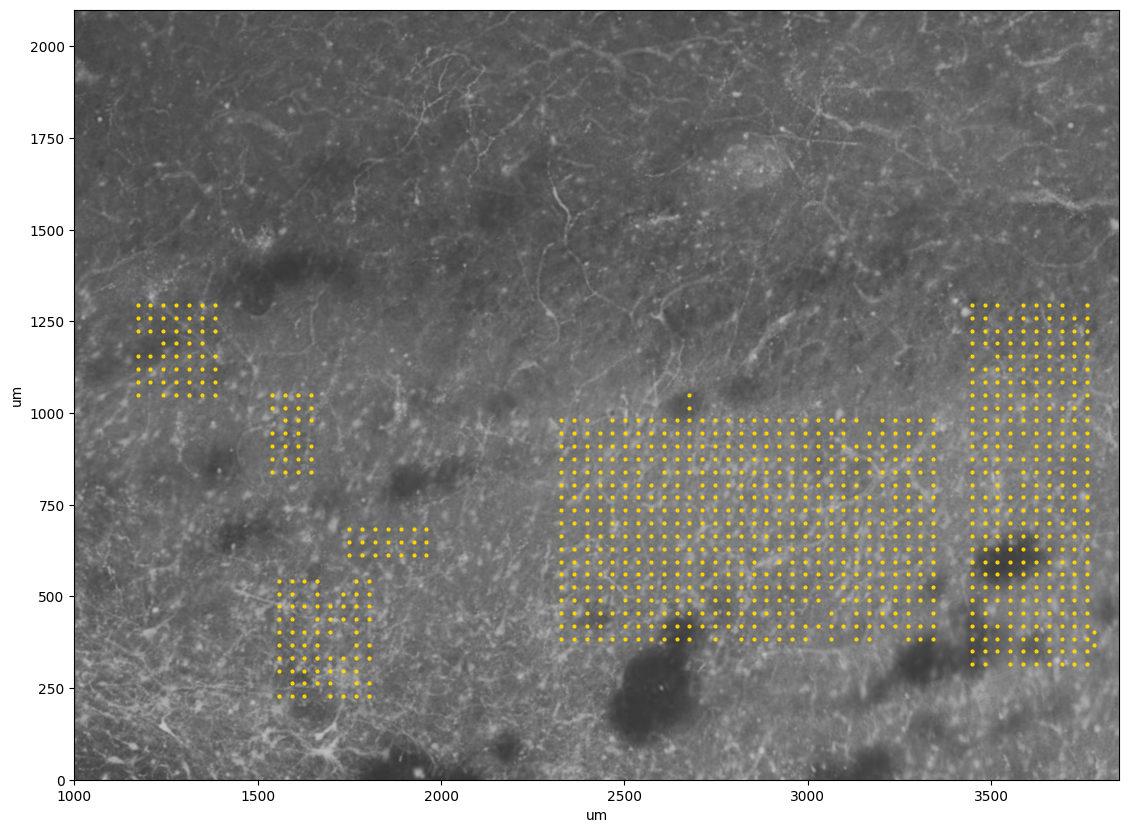

In [32]:
plt.figure(figsize=(15,10))       # Set image size to roughly the shape of the MEA
img = plt.imread( "/workspaces/human_hippocampus/data/histology/hc52_bw4.png")       # Load in image
plt.imshow(img,  extent=[0, 3850, 0, 2100]) # Plot image, have it correspond to electrode dimensions

electrode_mapping =  pd.DataFrame.from_dict( sd.metadata[0], orient="index", columns=['x','y']  ) 
plt.scatter( electrode_mapping.x.values, electrode_mapping.y.values, s=4, c='gold')


plt.xlim( 1000,3850 )    
#plt.xlim( 700,3000 )                                       # Set axis limits to that of the MEA
#plt.ylim( 0,2100)
plt.xlabel('um')                                         # add axises and title
plt.ylabel('um')

# HC111

# HC328

# HC110723